In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

import numpy as np
# https://github.com/eriklindernoren/Keras-GAN
import time
import os
import csv
from PIL import Image

root = 'CGAN_results/'

# plotting data structure
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
train_hist['accuracy'] = []
train_hist['Model'] = []
train_hist['classif_loss'] = []
train_hist['classif_acc'] = []

Using TensorFlow backend.


In [2]:
def trainClassif():
    (train_set, train_label_raw), (_, _) = mnist.load_data()
    train_label = to_categorical(train_label_raw)
    train_data = np.asarray(train_set).reshape(60000, 28, 28, 1)
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=43)

#     test_data = test_set.reshape(10000, 28, 28, 1)

    np.shape(train_data)

    model = Sequential()
    # model.add(Conv2D(5, kernel_size=3, activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # model.summary()

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4)
    return model

In [3]:
classif = trainClassif()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 40200 samples, validate on 19800 samples
Epoch 1/4
40200/40200 [==============================] - 9s 223us/step - loss: 14.4466 - acc: 0.1037 - val_loss: 14.4119 - val_acc: 0.1059
Epoch 2/4
40200/40200 [==============================] - 7s 168us/step - loss: 14.4465 - acc: 0.1037 - val_loss: 14.4119 - val_acc: 0.1059
Epoch 3/4
40200/40200 [==============================] - 7s 175us/step - loss: 14.4465 - acc: 0.1037 - val_loss: 14.4119 - val_acc: 0.1059
Epoch 4/4
40200/40200 [==============================] - 7s 177us/step - loss: 14.4465 - acc: 0.1037 - val_loss: 14.4119 - val_acc: 0.1059


In [4]:
class CGAN():
    def __init__(self, pick_model='Deep_BN'):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator(pick_model=pick_model)
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator(pick_model=pick_model)

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self, pick_model='Deep_BN'):
        if (pick_model == 'Deep_BN') | (pick_model == 'Deeper_D_BN'):
            model = Sequential()

            model.add(Dense(256, input_dim=self.latent_dim))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(1024))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(np.prod(self.img_shape), activation='tanh'))
            model.add(Reshape(self.img_shape))

            model.summary()

        elif (pick_model == 'Shallow_BN') | (pick_model == 'Deeper_G_BN'): 
            model = Sequential()

            model.add(Dense(256, input_dim=self.latent_dim))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(np.prod(self.img_shape), activation='tanh'))
            model.add(Reshape(self.img_shape))

            model.summary()
        elif pick_model == 'Shallow_Drop':
            model = Sequential()

            model.add(Dense(256, input_dim=self.latent_dim))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(np.prod(self.img_shape), activation='tanh'))
            model.add(Reshape(self.img_shape))

            model.summary()
        elif pick_model == 'Drop':
            model = Sequential()

            model.add(Dense(256, input_dim=self.latent_dim))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(1024))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Dense(np.prod(self.img_shape), activation='tanh'))
            model.add(Reshape(self.img_shape))

            model.summary()
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self, pick_model='Deep_BN'):
        if (pick_model == 'Deep_BN') | (pick_model == 'Deeper_D_BN'):
            model = Sequential()

            model.add(Dense(512, input_dim=np.prod(self.img_shape)))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))
            model.summary()
        
        elif (pick_model == 'Shallow_BN') | (pick_model == 'Deeper_G_BN'): 
            model = Sequential()

            model.add(Dense(512, input_dim=np.prod(self.img_shape)))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))
            model.summary()
        
        elif pick_model == 'Shallow_Drop':
            model = Sequential()

            model.add(Dense(512, input_dim=np.prod(self.img_shape)))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))
            model.summary()
        
        elif pick_model == 'Drop':
            model = Sequential()

            model.add(Dense(512, input_dim=np.prod(self.img_shape)))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(512))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))
            model.summary()
        
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50, ratio = (1,1), pick_model = 'Deep_BN'):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            epoch_start_time = time.time()
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])
            #implement ratio of D  
            if epoch % ratio[0] == 0:
                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
            #implement ratio of G
            if epoch % ratio[1] == 0:
                # Train the generator
                g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)
            
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - epoch_start_time
            
            # save data for plotting and csv
            train_hist['D_losses'].append(d_loss[0])
            train_hist['G_losses'].append(g_loss)
            train_hist['per_epoch_ptimes'].append(per_epoch_ptime)    
            train_hist['accuracy'].append(100 * d_loss[1])
            train_hist['Model'].append(pick_model)
            
            

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch, pick_model, ratio)
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                # REMEMBER TO CHANGE TO PARAM DIRECTORY
#                 os.makedirs('saved_model_weights', exist_ok=True)
#                 generator.save_weights('saved_model_weights/generator_weights_%d.h5'%epoch)
#                 discriminator.save_weights('saved_model_weights/discriminator_weights_%d.h5'%epoch)
#                 combined.save_weights('saved_model_weights/combined_weights-%d.h5'%epoch)

    def sample_images(self, epoch, pick_model, ratio):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs(root + 'images/'+  pick_model + '/'+ str(ratio[0]) + '_' + str(ratio[1]) + '/' , exist_ok=True)
        fig.savefig(root + 'images/'+  pick_model + '/'+ str(ratio[0]) + '_' + str(ratio[1]) + '/' + str(epoch) + '.png')
#         fig.savefig("images/%d.png" % epoch)
        plt.close()
        
    def generate_images(self, num):
        r, c = 2, 5
        arr_imgs = []
        arr_labels = []
        for i in range(0, num):
            noise = np.random.normal(0, 1, (2 * 5, 100))
            sampled_labels = np.arange(0, 10).reshape(-1, 1)
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
            arr_imgs.append(gen_imgs)
            arr_labels.append(sampled_labels)
            
        out_imgs = np.asarray(arr_imgs).reshape(num*10, 28, 28, 1)
        out_labels = np.asarray(arr_labels).reshape(num*10, 1)
        
        return out_imgs, out_labels

In [5]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))
    
    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    
    
    if save:
        
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [6]:
ratio_array = [ (1,1), (1,2), (1,3), (2,3), (3,2), (3,1), (2,1), (10,1), (1,10)]
model_array = ['Deep_BN' ] #'Drop' 'Shallow_BN' 'Shallow_Drop' 'Deeper_G_BN' 'Deeper_D_BN']

for pick_model in model_array:
    #---------------------------COMPILE SELECTED MODELS--------------------------------------#
    cgan = CGAN(pick_model=pick_model)
    #----------------------------------------LOOP OVER RATIOS--------------------------------#
    for ratio in ratio_array:
         #----------------------------------------EXECUTION-----------------------------------#
        start = time.time()

        cgan.train(epochs=20001, batch_size=128, sample_interval=200, ratio=ratio, pick_model=pick_model) ## ratio G:D
        
        end = time.time()
        
        elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                             int((end - start) % 60))
        train_hist['total_ptime'].append(elapsed_train_time)

        print(elapsed_train_time)
        os.makedirs(root + 'hist/', exist_ok=True)  
        show_train_hist(train_hist, save=True, path=root + 'hist/' + str(ratio[0]) + '_' + str(ratio[1]) + pick_model +'.png')
        # save hist data to csv
        gen_images, gen_labels = cgan.generate_images(1000)
        loss, acc = classif.evaluate(gen_images, to_categorical(gen_labels))
        train_hist['classif_loss'].append(loss)
        train_hist['classif_acc'].append(acc)
        
        os.makedirs(root + 'hist_csv/', exist_ok=True) 
        with open(root+ 'hist_csv/' + str(ratio[0]) + '_' + str(ratio[1]) + pick_model +'.csv', 'w') as f:
            for key in train_hist.keys():
                f.write("%s,%s\n"%(key,train_hist[key]))
        
        
        # remove old data structure
        del train_hist
        # redefine
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_ptimes'] = []
        train_hist['total_ptime'] = []
        train_hist['accuracy'] = []
        train_hist['Model'] = []
        train_hist['classif_loss'] = []
        train_hist['classif_acc'] = []
        gen_images, gen_labels = cgan.generate_images(1000)
        loss, acc = classif.evaluate(gen_images, to_categorical(gen_labels))
        
            
        

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
___________________________

C:\Users\Jack\venv\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.703743, acc.: 2.34%] [G loss: 0.692811]
200 [D loss: 0.590690, acc.: 62.50%] [G loss: 2.020267]
elapsed training time: 0 min, 9 sec 
10000/10000 [==============================] - 1s 63us/step
0 [D loss: 0.512083, acc.: 72.66%] [G loss: 1.949608]
200 [D loss: 0.508209, acc.: 75.00%] [G loss: 2.017418]
elapsed training time: 0 min, 5 sec 
10000/10000 [==============================] - 1s 61us/step
0 [D loss: 0.469999, acc.: 76.95%] [G loss: 2.163162]
200 [D loss: 0.435567, acc.: 80.86%] [G loss: 2.768640]
elapsed training time: 0 min, 5 sec 
10000/10000 [==============================] - 1s 62us/step
0 [D loss: 0.412530, acc.: 83.20%] [G loss: 2.614779]
200 [D loss: 0.600529, acc.: 60.94%] [G loss: 1.821091]
elapsed training time: 0 min, 4 sec 
10000/10000 [==============================] - 1s 63us/step
0 [D loss: 0.580877, acc.: 72.27%] [G loss: 2.140772]
200 [D loss: 0.664184, acc.: 52.73%] [G loss: 1.653927]
elapsed training time: 0 min, 3 sec 
10000/10000 [=============

In [7]:
# gen_images, gen_labels = cgan.generate_images(1000)
# loss, acc = classif.evaluate(gen_images, to_categorical(gen_labels))

In [8]:
print(loss)
print(acc)

2.4406905708312987
0.1


(10000, 1)
(10000, 28, 28, 1)
[4]
['loss', 'acc']


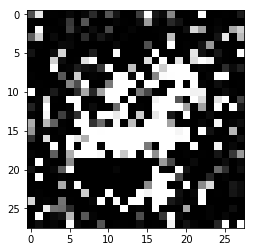

In [9]:
print(gen_labels.shape)
print(gen_images.shape)

print(gen_labels[5004])
plt.imshow(gen_images[5004,:,:, 0], cmap='gray')

print(classif.metrics_names)